<a href="https://colab.research.google.com/github/lingesh0/kovai.co_task/blob/main/forecast(SARIMA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Auto-ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=35372.614, Time=9.61 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=38271.040, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=9.48 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=37069.620, Time=4.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=38269.043, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=36587.208, Time=4.18 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=7.57 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=35360.883, Time=14.71 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=15.70 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=35343.551, Time=18.36 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=35365.852, Time=16.32 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=16.80 sec
 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.61 sec
 ARIMA(3,1,2)(2,0,2)[7] intercept   : AIC=35265.089, Time=18.87 sec
 ARIMA(3,1,2)(1,0,2)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA Model Summary:

                                      SARIMAX Results                                      
Dep. Variable:                         Rapid Route   No. Observations:                 1904
Model:             SARIMAX(5, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -17444.588
Date:                             Thu, 04 Dec 2025   AIC                          34909.176
Time:                                     06:04:22   BIC                          34964.625
Sample:                                 07-01-2019   HQIC                         34929.594
                                      - 09-15-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3876      0.062      6.267      0.000       0.266       0.509
ar.

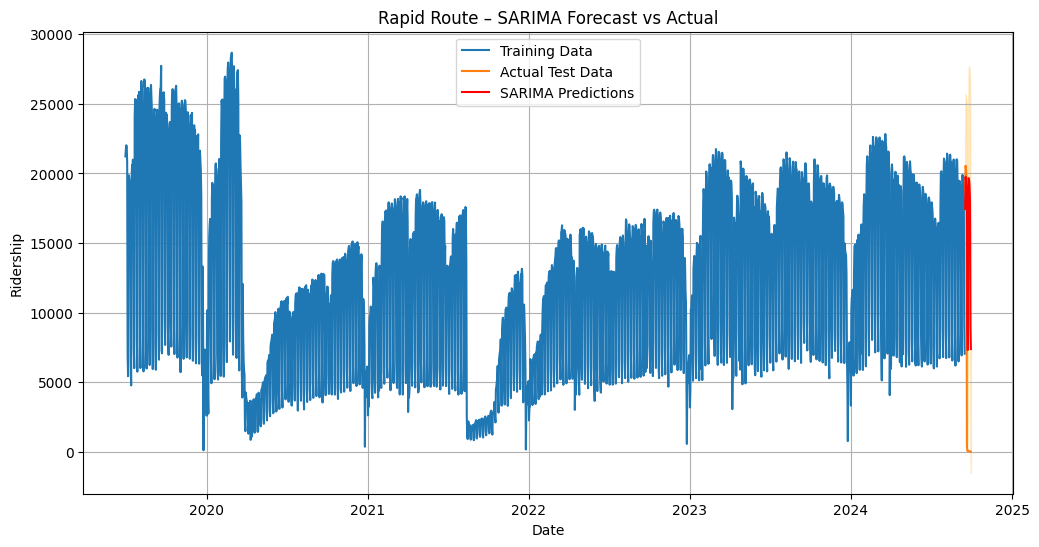

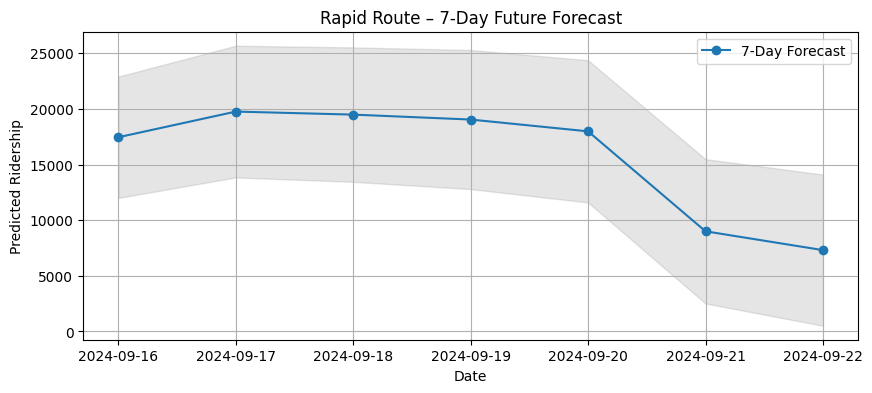

In [2]:
# ==============================================
# SARIMA Forecasting – Full Pipeline
# ==============================================

!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Load & Prepare the Dataset
# -----------------------------
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date").set_index("Date")

SERVICE = "Rapid Route"   # CHANGE THIS TO ANY SERVICE (Local Route, Light Rail, Peak Service, School)

series = df[SERVICE]

# -----------------------------
# 2. Train-Test Split
# -----------------------------
train = series[:-14]
test = series[-14:]

# -----------------------------
# 3. Auto-ARIMA for Best Params
# -----------------------------
print("Running Auto-ARIMA...")
model_auto = auto_arima(train,
                        seasonal=True, m=7,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)

print("\nBest Model:", model_auto.order, model_auto.seasonal_order)

# -----------------------------
# 4. Fit SARIMA Model
# -----------------------------
sarima_model = SARIMAX(train,
                       order=model_auto.order,
                       seasonal_order=model_auto.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)
print("\nSARIMA Model Summary:\n")
print(sarima_results.summary())

# -----------------------------
# 5. Forecast on Test Set
# -----------------------------
pred_test = sarima_results.get_forecast(steps=14)
pred_mean = pred_test.predicted_mean
pred_ci = pred_test.conf_int()

# Evaluation Metrics
mae = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))
mape = np.mean(np.abs((test - pred_mean) / test)) * 100
r2 = r2_score(test, pred_mean)

print(f"\nModel Evaluation for {SERVICE}")
print("----------------------------------")
print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R2 Score:", r2)

# -----------------------------
# 6. Final Forecast (Next 7 Days)
# -----------------------------
future_forecast = sarima_results.get_forecast(steps=7)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

print("\nNext 7-Day Forecast:")
print(future_mean)

# -----------------------------
# 7. Visualization: Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual Test Data")
plt.plot(pred_mean.index, pred_mean, label="SARIMA Predictions", color="red")

# Confidence interval shading
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 alpha=0.2, color="orange")

plt.title(f"{SERVICE} – SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Visualization: 7-Day Forecast
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(future_mean.index, future_mean, marker='o', label="7-Day Forecast")
plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1],
                 alpha=0.2, color="gray")

plt.title(f"{SERVICE} – 7-Day Future Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Ridership")
plt.legend()
plt.grid(True)
plt.show()